In [3]:
# assign directory
import git
from pathlib import Path
import os
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from transform import *
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "dataset-preparation"))

data_dir  = os.path.join(ROOT_DIR, 'raw-data', 'ravdess','full-ravdess-wav')
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

## Audio Processing using Librosa and soundfile

* Detects audio files that contain clipping and removes them from the data set
* Filters out beginning and end silence 
* Normalizes loudness

In [4]:
import librosa #Need to pip install librosa 
import soundfile as sf #Need to pip install soundfile

In [5]:
#Creates new wav files that have been processed

CLIP_THRESHOLD = 0.99
OUTPUT_DIR = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-wave-processed')

def is_clipped(y, threshold = CLIP_THRESHOLD):
    return np.any(np.abs(y) >= threshold)

def normalize_peaks(y):
    return y / np.max(np.abs(y)) if np.max(np.abs(y)) > 0 else y

def process_audio_file(filepath, outpath):
    y, sr = librosa.load(filepath, sr=None)

    if is_clipped(y):
        return

    y_trimmed, _ = librosa.effects.trim(y, top_db=20)

    y_normalized = normalize_peaks(y_trimmed) 

    sf.write(outpath, y_normalized, sr)

for filename in file_names:
    if filename.lower().endswith('wav'):
        path_in = os.path.join(data_dir, filename)
        path_out = os.path.join(OUTPUT_DIR, filename)
        process_audio_file(path_in, path_out)



In [6]:
#Changes dataset to post-processed dataset
data_dir = OUTPUT_DIR
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

## numpy representation

using `scipy.io.wavfile.read(filename)` to intake .wav audio files 

> returns 
> * rate, registing the hertz of the audio 
> * data, an array with each index representing a point in time for the audio and its value representing amplitude at said time 
>   * index position divided by the length of array represents its temporal occurence in seconds

In [7]:
from scipy.io import wavfile

In [8]:
wav_rates, wav_coeffs = zip(*[wavfile.read(file) for file in file_list])
wav_rates = np.array(wav_rates)
wav_coeffs = np.array(wav_coeffs, dtype="object")

In [9]:
assert len(wav_rates) == len(wav_rates), "Check for lossy data in .wav scipy numpy representation"
n = len(wav_rates)
n

1420

In [10]:
wav_lengths = pd.Series(wav_coeffs).apply(len) / wav_rates[0]

## info parsing to .csv

file naming conventions (from RAVDESS)

In [11]:
modalities = {
    "01": "full-AV", 
    "02": "video-only",
    "03": "audio-only"
} 

channels = {
    "01": "speech",
    "02": "song"
}

emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "suprised",
} 

intensities = {
    "01": "normal",
    "02": "strong"
}

statements = {
    "01": "Kids are talking by the door",
    "02": "Dogs are sitting by the door"
}

speaker_sex = ["female", "male"] 

In [13]:
ravdess_cols = ["modality", "channel", "emotion", "intensity", "statement", "repetition", "actor", "sex", "filename"]
rows = []

for f in file_names:
    if f != ".DS_Store":
        parsed_info = f[:-4].split("-")

        modality = modalities[parsed_info[0]]
        channel = channels[parsed_info[1]]
        emotion = emotions[parsed_info[2]]
        intensity = intensities[parsed_info[3]]
        sentence = statements[parsed_info[4]]
        rep = int(parsed_info[5])
        no1 = int(parsed_info[6])
        sx = speaker_sex[no1 % 2]

        rows.append({
            "modality": modality,
            "channel": channel,
            "emotion": emotion,
            "intensity": intensity,
            "statement": sentence,
            "repetition": rep,
            "actor": no1,
            "sex": sx,
            "filename": f
        })

ravdess_df = pd.DataFrame(rows, columns=ravdess_cols)


ravdess_df["length (s)"] = wav_lengths
ravdess_df["rate (Hz)"] = wav_rates
ravdess_df["amplitudes"] = wav_coeffs

ravdess_df.head()

,modality,channel,emotion,intensity,statement,repetition,actor,sex,filename,length (s),rate (Hz),amplitudes
0,audio-only,speech,neutral,normal,Kids are talking by the door,1,1,male,03-01-01-01-01-01-01.wav,1.194667,48000,"[-1898, -666, 295, -1011, -1922, -567, 813, 54..."
1,audio-only,speech,neutral,normal,Kids are talking by the door,1,2,female,03-01-01-01-01-01-02.wav,1.493333,48000,"[233, -363, -947, -1284, -1439, -1336, -1141, ..."
2,audio-only,speech,neutral,normal,Kids are talking by the door,1,3,male,03-01-01-01-01-01-03.wav,1.344000,48000,"[-369, -148, 206, 545, 826, 826, 472, 44, -561..."
3,audio-only,speech,neutral,normal,Kids are talking by the door,1,4,female,03-01-01-01-01-01-04.wav,1.269333,48000,"[1050, 859, -550, -478, -598, -2341, -2222, -2..."
4,audio-only,speech,neutral,normal,Kids are talking by the door,1,5,male,03-01-01-01-01-01-05.wav,1.525333,48000,"[-661, 105, 237, 184, 766, 475, -608, -1031, -..."


In [14]:
xport_name = "full-ravdess.csv"
EXPORT_DIR = os.path.join(ROOT_DIR, "raw-data", "ravdess")
EXPORT_PATH = os.path.join(EXPORT_DIR, xport_name)

ravdess_df.to_csv(EXPORT_PATH)

## npz representation export

In [15]:
EXPORT_DIR = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-npz')

for f in np.arange(len(file_list)):
    coef = wav_coeffs[f]
    file_name = file_list[f][-24:-4] ## removes the .wav naming convention

    np.savez(os.path.join(EXPORT_DIR, file_name))

## banding

consideration for a "banding method" to group adjacent audio bytes in a similar fashion to how the image teams doing 

* tied to the transformation in use 

# Wavelet representation
Morlet continuous wavelet transform on some example files to start

In [16]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

In [17]:
test_file_idx = 42
print(ravdess_df.iloc[test_file_idx])

rate, signal = wavfile.read(file_list[test_file_idx])

wavelet = 'cmor1.5-1.0' # complex morlet: bandwidth = 1.5, center frequency = 1.0
low_freq, high_freq = 80, 4000  # typical range for human speech
num_scales = 100  # can be adjusted for computational efficiency

frequencies = np.logspace(np.log10(low_freq), np.log10(high_freq), num_scales)
scales = pywt.frequency2scale(wavelet, frequencies / rate)
coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/rate)

modality                                             audio-only
channel                                                  speech
emotion                                                 neutral
intensity                                                normal
statement                          Kids are talking by the door
repetition                                                    2
actor                                                        19
sex                                                        male
filename                               03-01-01-01-01-02-19.wav
length (s)                                                1.344
rate (Hz)                                                 48000
amplitudes    [305, 244, 91, 61, 152, 275, 275, 122, 30, 152...
Name: 42, dtype: object


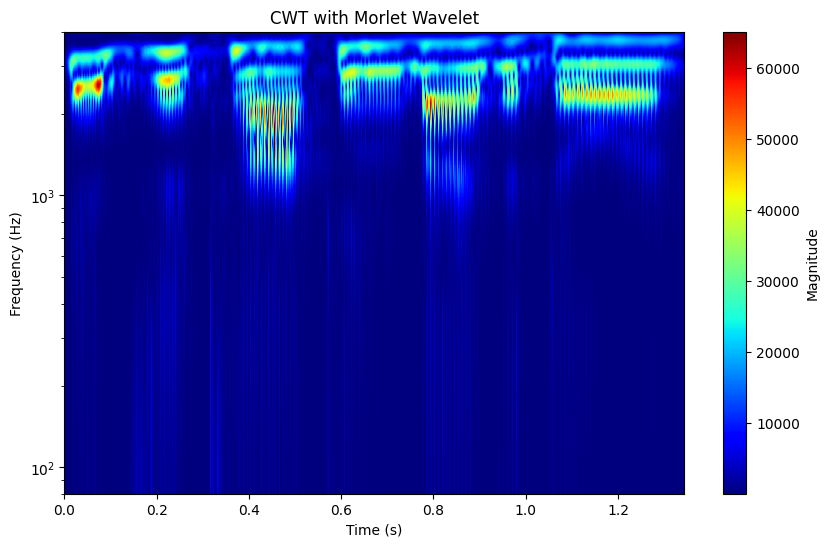

In [18]:
plt.figure(figsize=(10, 6))
plt.imshow(
    np.abs(coefs),
    aspect='auto',
    cmap='jet',
    extent=[0, len(signal)/rate, low_freq, high_freq]
)
plt.colorbar(label='Magnitude')
plt.yscale('log') # log scale frequency axis
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('CWT with Morlet Wavelet')
plt.show()

In [19]:
# generalize above logic into function

def cwt_file(filename, wavelet='cmor1.5-1.0', low_freq=80, high_freq=4000, num_scales=100, visualize=False, title='CWT with Morlet Wavelet'):
    rate, signal = wavfile.read(os.path.join(data_dir, filename)) # currently references global data_dir
    frequencies = np.logspace(np.log10(low_freq), np.log10(high_freq), num_scales)
    scales = pywt.frequency2scale(wavelet, frequencies / rate)
    coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/rate)

    if visualize:
        plt.figure(figsize=(10, 6))
        plt.imshow(
            np.abs(coefs),
            aspect='auto',
            cmap='jet',
            extent=[0, len(signal)/rate, low_freq, high_freq]
        )
        plt.colorbar(label='Magnitude')
        plt.yscale('log')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(title)
        plt.show()

    return coefs, freqs

In [20]:
# compare male versus female

from functools import reduce

def homogenize(df, *cols):
    return df[reduce(lambda a, b: a & b, (df[col] == df[col][0] for col in cols), np.ones(df.shape[0]))]

hom_df = homogenize(ravdess_df, 'statement', 'emotion', 'intensity')
male_vs_female = hom_df.groupby('sex').first()
male_vs_female

,modality,channel,emotion,intensity,statement,repetition,actor,filename,length (s),rate (Hz),amplitudes
sex,,,,,,,,,,,
female,audio-only,speech,neutral,normal,Kids are talking by the door,1,2,03-01-01-01-01-01-02.wav,1.493333,48000,"[233, -363, -947, -1284, -1439, -1336, -1141, ..."
male,audio-only,speech,neutral,normal,Kids are talking by the door,1,1,03-01-01-01-01-01-01.wav,1.194667,48000,"[-1898, -666, 295, -1011, -1922, -567, 813, 54..."


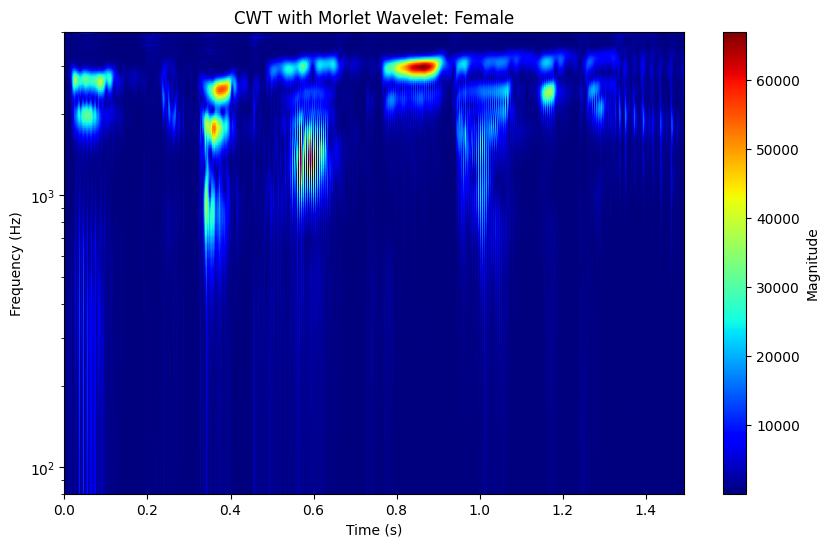

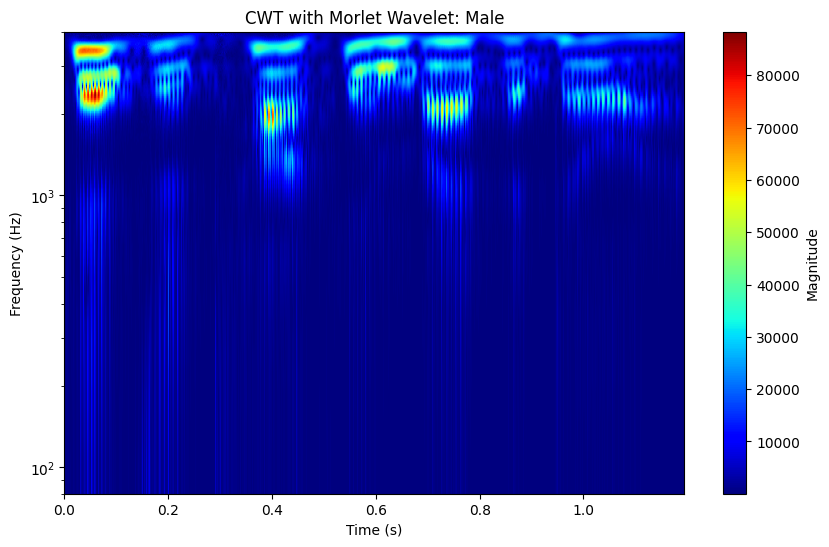

In [30]:
for sex, filename in zip(male_vs_female.index, male_vs_female['filename']):
    cwt_file(filename, visualize=True, title=f'CWT with Morlet Wavelet: {sex.capitalize()}')